In [1]:
__imp

Libraries have been loaded


# TODOS

- Feature Selection
    - Merge feature groups using aggregate features.

## Load Additional Libraries

In [2]:
import multiprocessing as mp

basepath = os.path.expanduser('../')

## Load Data

In [3]:
%%time

app_train  = pd.read_feather(os.path.join(basepath, 'data/processed/application_train.feather'))
# app_test   = pd.read_feather(os.path.join(basepath, 'data/processed/application_test.feather'))

# bureau     = pd.read_feather(os.path.join(basepath, 'data/processed/bureau.feather'))
# bureau_bal = pd.read_feather(os.path.join(basepath, 'data/processed/bureau_balance.feather'))

# prev_app  = pd.read_pickle(os.path.join(basepath, 'data/processed/prev_app.pkl'))
# pos_cash  = pd.read_pickle(os.path.join(basepath, 'data/processed/pos_cash.pkl'))

# credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/processed/credit_card_balance.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/processed/installments_payments.pkl'))

CPU times: user 177 ms, sys: 125 ms, total: 303 ms
Wall time: 1.69 s


### EDA

#### Weight Of Evidence

For both categorical and numerical variables.

- Check if data is continuous or categorical.
- For continuous data, create bins.
- Calculate number of non-events and events in every bin.
- Calculate WOE by taking natural log of division of percentage of non events and events.

In [9]:
def woe(df, f):
    print('Number of unique values: {}'.format(df[f].nunique()))
    
    if df.loc[:, f].nunique() <= 10:
        # categorical
        feature_with_missing = pd.factorize(df[f])[0]
        
        grouped       = df.groupby([feature_with_missing, 'TARGET']).size().unstack().fillna(0)
        grouped_share = grouped / grouped.sum()
        
        woe = grouped_share.apply(lambda x: np.log(x[0.0] / x[1.0]), axis=1)
        iv  = grouped_share.apply(lambda x: x[0] - x[1], axis=1) * woe.values
        
        return f, iv.sum() 
    else:
        # feature bins
        feature_binned = pd.cut(df[f], bins=10, labels=np.arange(10))
        
        grouped       = df.groupby([feature_binned, 'TARGET']).size().unstack().fillna(0)
        grouped_share = grouped / grouped.sum()
        
        woe = grouped_share.apply(lambda x: np.log(x[0.0] / x[1.0]), axis=1)
        iv  = grouped_share.apply(lambda x: x[0] - x[1], axis=1) * woe.values
        
        return f, iv.sum()

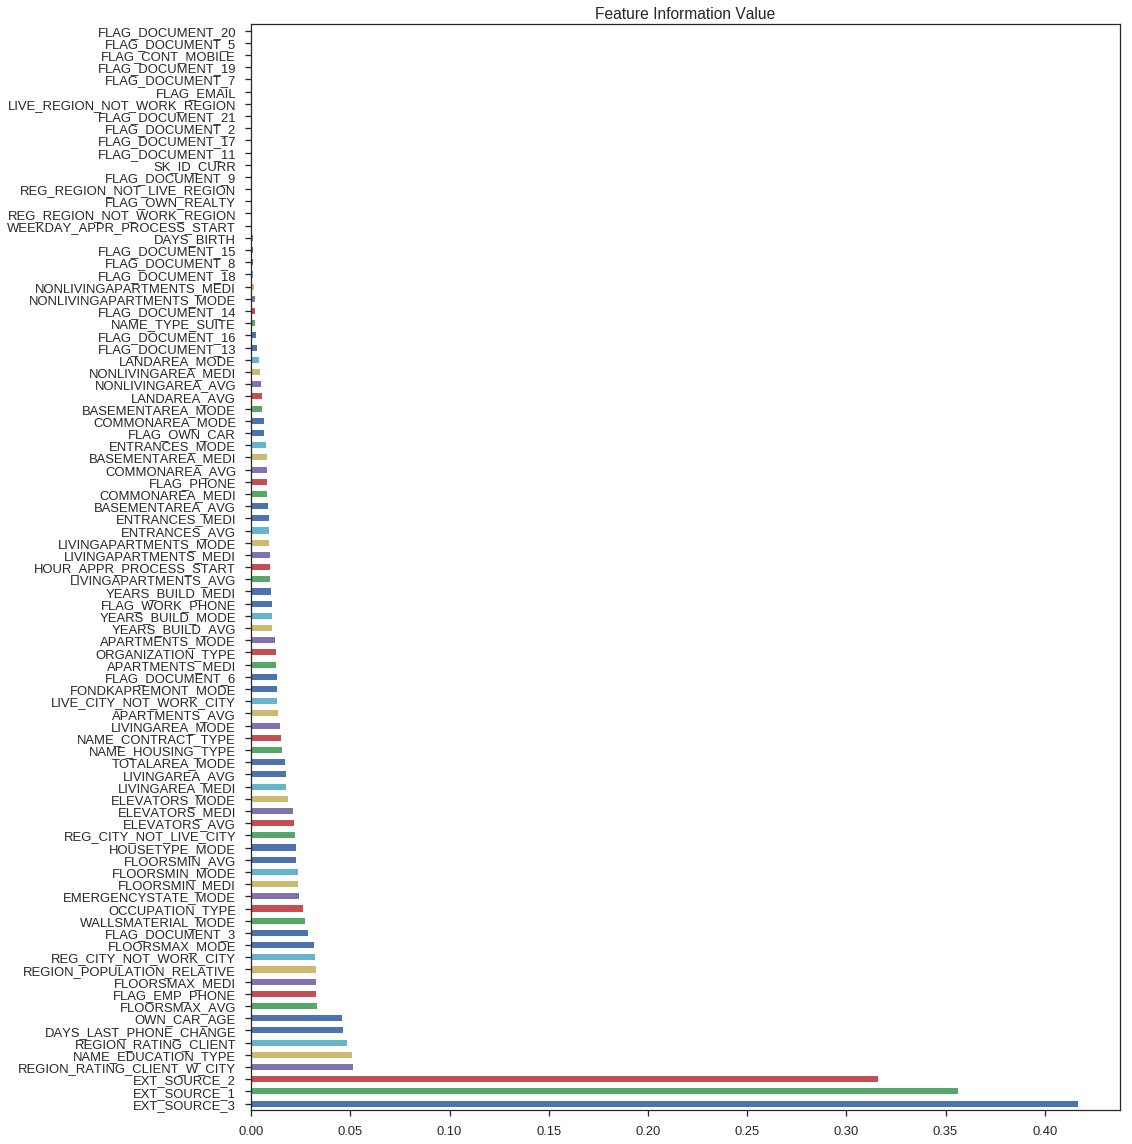

In [155]:
plt.figure(figsize=(16, 16))
pd.Series(feat_iv).sort_values(ascending=False).plot(kind='barh')
plt.tight_layout()
plt.title('Feature Information Value');

In [10]:
flag_cols = [f for f in app_train.columns if 'FLAG' in f]
res = app_train.loc[:, flag_cols].apply(np.sum, axis=1)
pd.crosstab(res, app_train.TARGET)

TARGET,0.0,1.0
row_0,,
1,8,0
2,1570,86
3,30072,1891
4,79987,7193
5,85243,7902
6,54638,5101
7,24580,2183
8,5961,435
9,604,32


In [13]:
app_train.loc[:, 'AMT_REQ_CREDIT_BUREAU_DAY'].value_counts(dropna=False)

 0.0    264503
NaN      41519
 1.0      1292
 2.0       106
 3.0        45
 4.0        26
 5.0         9
 6.0         8
 9.0         2
 8.0         1
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64

In [15]:
ss = pd.crosstab(app_train.AMT_REQ_CREDIT_BUREAU_DAY, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
AMT_REQ_CREDIT_BUREAU_DAY,,,
0.0,244111,20392,0.077096
1.0,1167,125,0.096749
2.0,95,11,0.103774
3.0,43,2,0.044444
4.0,23,3,0.115385
5.0,9,0,0.000000
6.0,8,0,0.000000
8.0,1,0,0.000000
9.0,2,0,0.000000


In [21]:
res = app_train.loc[:, [f for f in app_train.columns if 'AMT_REQ_CREDIT' in f]].apply(np.mean, axis=1)

In [22]:
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
row_0,,,
0.000000,47156,3755,0.073756
0.166667,49917,3997,0.074137
0.333333,47586,3973,0.077057
0.500000,36344,3036,0.077095
0.666667,25081,2160,0.079292
0.833333,15803,1445,0.083778
1.000000,9892,883,0.081949
1.166667,5850,578,0.089919
1.333333,3516,318,0.082942
